# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Заказчик.** Добывающая компания «ГлавРосГосНефть»

**Цель Заказчика.** Определить наиболее эффективное место для бурения скважины.

**Цель исследования.** Построить модель для определения региона, где добыча принесёт наибольшую прибыль.

**Задачи:**

- Загрузить и подготовить данные.
- Обучить и проверьте модель для каждого региона
- Подготовить данные к расчёту прибыли
- Создать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
- Посчитать риски и прибыль для каждого региона

**Условия:**

- Для обучения модели подходит только линейная регрессия 
- При разведке региона исследовать 500 точек, из которых с помощью машинного обучения выбрать 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков оставить только те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбрать регион с наибольшей средней прибылью.


**Входные данные от Заказчика.** Три файла в формате .csv с указанием различных параметров разработки скважин и объемов запаса в каждой скважине.

**Ожидаемый результат.** Определено и обосновано место для бурения скважины.

## Загрузка и подготовка данных

1. Открыть таблицу 
2. Изучить структуру данных по десяти первым строкам
3. Изучить структуру данных методом `info()`
4. Выявить пропуски и дубликаты

**Описание данных**

**Признаки**

- `id` — уникальный идентификатор скважины
- `f0`, `f1`, `f2` — значимые признаки точек

**Условно целевой признак**

- `product` — объём запасов в скважине (тыс. баррелей)

In [32]:
# Импотрт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
from numpy.random import RandomState

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score # кросс-вылидация
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # стандартизация
from sklearn.utils import shuffle # перемешивание
from sklearn.dummy import DummyClassifier # Наивная модель

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import confusion_matrix # матрица "правда / ложь"
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve # график
from sklearn.metrics import roc_auc_score # площадь фигуры по графику

In [33]:
# Введем константу
state = RandomState(12345)

In [34]:
# Функция исследования датасета
def info_df(df_name):
    display(df_name.head())
    st = df_name.shape[0]
    col = df_name.shape[1]
    uniq = df_1.shape[0] - len(df_name['id'].unique())
    print(f'Размер таблиы: {col} столбцов и {st} строк')
    print(f'Количество явных дубликатов: {df_name.duplicated().sum()}')
    print(f'Количество НЕ явных дубликатов: {uniq}')
    print()
    print(df_name.info())


In [35]:
df_1 = pd.read_csv('/datasets/geo_data_0.csv')
info_df(df_1)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Размер таблиы: 5 столбцов и 100000 строк
Количество явных дубликатов: 0
Количество НЕ явных дубликатов: 10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [36]:
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
info_df(df_2)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Размер таблиы: 5 столбцов и 100000 строк
Количество явных дубликатов: 0
Количество НЕ явных дубликатов: 4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [37]:
df_3 = pd.read_csv('/datasets/geo_data_2.csv')
info_df(df_3)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Размер таблиы: 5 столбцов и 100000 строк
Количество явных дубликатов: 0
Количество НЕ явных дубликатов: 4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Каждая из трех таблиц содержит столбец с указанием id скважины, три столбца с параметрами и столбец с целевым параметром – объемом запасов нефти в скважине.

Каждая таблица содержит 100 000 строк

Все таблицы лишены пропусков и имеют корректные типы данных.

Во всех таблицах есть не явные дубликаты – строки с одинаковым id, но с разными данными. 

Учитывая крайне малое число таких строк, то вероятнее всего, это результат технической ошибки и у нас нет возможности определить, какая строка верная.

Однако, в рамках решения задачи прогнозирования эффективности добычи нет смысла в персонализации скважин региона. Излишняя детализация данных сужает возможности обучения модели за счет чрезмерной кластеризации. Поэтому для решения текущей задачи, нам не потребуется информация об id скважины.

В этой связи, менять строки с не явными дубликатами не имеет смысла.

In [38]:
# Разделим данные на признаки и целевые занчения

def features_target(df):
    features = df.drop(['id', 'product'], axis=1)
    target = df_1['product']
    return features, target

features_1, target_1 = features_target(df_1)
features_2, target_2 = features_target(df_1)
features_3, target_3 = features_target(df_1)

**Вывод**

В результате анализа имеющихся данных выявлено присутствие неявных дубликатов, удалять которые не представляется целесообразным.  

Все три таблицы, описывающие скважины разных регионов разделены на таблицы признаков и целей, что финализирует процесс подготовки данных для дальнейшей работы.

## Обучение и проверка модели

1. Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
2. Обучить модель и сделать предсказания на валидационной выборке.
3. Сохранить предсказания и правильные ответы.
4. Напечатать на экране средний запас предсказанного сырья и RMSE модели.
5. Проанализировать результаты.

In [39]:
# Разобьем данные на обучающую и валидационную выборки в соотношении 75:25

def train_valid(features, target, reg):
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                                  test_size=.25,
                                                                                  random_state=state)
    print(f'features_train_ {reg} - {features_train.shape[0]} строк')
    print(f'features_valid_ {reg} - {features_valid.shape[0]} строк')
    print()
    return features_train, features_valid, target_train, target_valid

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_valid(features_1, target_1, 1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_valid(features_2, target_2, 2)
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_valid(features_3, target_3, 3)

features_train_ 1 - 75000 строк
features_valid_ 1 - 25000 строк

features_train_ 2 - 75000 строк
features_valid_ 2 - 25000 строк

features_train_ 3 - 75000 строк
features_valid_ 3 - 25000 строк



In [40]:
# Стандартизируем данные

numeric = ['f0', 'f1', 'f2']
pd.options.mode.chained_assignment = None

def scaler(features_train, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    return features_train, features_valid

features_train_1, features_valid_1 = scaler(features_train_1, features_valid_1)
features_train_2, features_valid_2 = scaler(features_train_2, features_valid_2)
features_train_3, features_valid_3 = scaler(features_train_3, features_valid_3)

In [41]:
# Обучим модель метолдом линейной регрессии и сделаем предсказания на валидационной выборке
# методом mean_squared_error определим RMSE модели
# выведем на печать среднее значение запаса предсказанного сырья

model = LinearRegression()

# Регион 1
model.fit(features_train_1, target_train_1)
predict_valid_1 = model.predict(features_valid_1)
rmse_valid_1 = mean_squared_error(predict_valid_1, target_valid_1) ** 0.5
predict_mean_product_1 = sum(predict_valid_1) / len(predict_valid_1)

print(f'По региону {1} среднее значение предсказанного запаса сырья {predict_mean_product_1:.4f},\
 RMSE {rmse_valid_1:.4f}')
print()

# Регион 2
model.fit(features_train_2, target_train_2)
predict_valid_2 = model.predict(features_valid_2)
rmse_valid_2 = mean_squared_error(predict_valid_2, target_valid_2) ** 0.5
predict_mean_product_2 = sum(predict_valid_2) / len(predict_valid_2)
print(f'По региону {2} среднее значение предсказанного запаса сырья {predict_mean_product_2:.4f},\
 RMSE {rmse_valid_2:.4f}')
print()

# Регион 3
model.fit(features_train_3, target_train_3)
predict_valid_3 = model.predict(features_valid_3)
rmse_valid_3 = mean_squared_error(predict_valid_3, target_valid_3) ** 0.5
predict_mean_product_3 = sum(predict_valid_3) / len(predict_valid_3)
print(f'По региону {3} среднее значение предсказанного запаса сырья {predict_mean_product_3:.4f},\
 RMSE {rmse_valid_3:.4f}')
print()

По региону 1 среднее значение предсказанного запаса сырья 92.5926, RMSE 37.5794

По региону 2 среднее значение предсказанного запаса сырья 92.4013, RMSE 37.9172

По региону 3 среднее значение предсказанного запаса сырья 92.5257, RMSE 37.7631



**Вывод**

В результате обучения модели методом линейной регрессии построен прогноз на валидационной выборке. По всем регионам среднее прогнозируемое значение запасов сырья в одной скважине примерно одинаковое (отклонения не превышают 0.2%. При этом значение среднеквадратичного отклонения составляет очень высокую величину и достигает 40% от уровня прогноза, что говорит о низкой точности сделанных прогнозов.

## Подготовка к расчёту прибыли

1. Все ключевые значения для расчётов сохранить в отдельных переменных.
2. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.
3. Сделать выводы по этапу подготовки расчёта прибыли.

In [42]:
# Введем переменные
profit_prod = 450000
budget = 10000000000
point_dirty = 500
point_clean = 200

In [43]:
# Точка безубыточности
profit_prod_point_min = budget / (profit_prod * point_clean)
profit_point_min = profit_prod_point_min * profit_prod
print(f'Минимальный безубыточный объем {profit_prod_point_min:.0f} тыс. баррелей на скважину')
print(f'Минимальный безубыточная выручка {profit_point_min / 1000000:.0f} млн.руб. на скважину')

Минимальный безубыточный объем 111 тыс. баррелей на скважину
Минимальный безубыточная выручка 50 млн.руб. на скважину


**Вывод**

Располагаемые данные говорят о том, что при разработке в регионе 200 скважин, безубыточный объем составляет 111 тыс.барр с каждой скважины. Учитывая полученные в результате прогноза средние значения запасов сырья скважин на уровне 92.5 тыс.барр, можно говорить о недостаточном фактическом объеме запасов сырья. 

Однако, высокий уровень среднеквадратичного отклонения говорит об имеющейся вероятности нахождения скважин с большими запасами, которые смогут преодолеть указанный уровень безубыточности.

## Расчёт прибыли и рисков 

1. Выбрать скважины с максимальными значениями предсказаний.
2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитать прибыль для полученного объёма сырья.
4. Применить технику Bootstrap с 1000 выборок, для поиска распределения прибыли.
5. Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков (отрицательной прибыли).
6. Сделать выводы. Предложить регион для разработки скважин и обосновать выбор.

In [44]:
# Преобразование predict_valid в Series

def transformations(target_valid, predict_valid):
    target_index = list(target_valid.index)
    predict_valid_ser = pd.Series(data=predict_valid, index=target_index)
    predict_valid = predict_valid_ser
    return predict_valid

predict_valid_1 = transformations(target_valid_1, predict_valid_1)
predict_valid_2 = transformations(target_valid_2, predict_valid_2)
predict_valid_3 = transformations(target_valid_3, predict_valid_3)

In [45]:
# Расчетаем прибыль по скважинам, предсказанными моделью

def profit_predict(target_valid, predict_valid, point, reg):
    bsest_point_list = predict_valid.sort_values(ascending=False)[:point]
    best_point_product = target_valid[bsest_point_list.index]
    profit_predict = sum(best_point_product) * profit_prod - budget
    print(f'Прибыль {point} скважин с максимальными значениями в регионе {reg}: {profit_predict / 1000000:.0f} млн.руб.')
    
profit_predict_1 = profit_predict(target_valid_1, predict_valid_1, point_clean, 1)
profit_predict_2 = profit_predict(target_valid_2, predict_valid_2, point_clean, 2)
profit_predict_3 = profit_predict(target_valid_3, predict_valid_3, point_clean, 3)

Прибыль 200 скважин с максимальными значениями в регионе 1: 3321 млн.руб.
Прибыль 200 скважин с максимальными значениями в регионе 2: 3267 млн.руб.
Прибыль 200 скважин с максимальными значениями в регионе 3: 3181 млн.руб.


In [46]:
# Короткий расчет прибыли
def profit_predict_all(predict, point):
    best_point_list = sorted(predict, reverse=True)[:point]
    return sum(best_point_list) * profit_prod - budget

# Ффункция для построенимя гистограммы
def hist_pattern(df, bi, title):
    df.hist(bins=bi, figsize=(10,7))
    plt.title(title)
    return plt.show()

# Расчет основных метрик и построения графика
def values_predict(predict_valid, reg):
    values = []
    for i in range(1000):
        subsample = predict_valid.sample(n=point_dirty, replace=True, random_state=state)
        profit_predict = profit_predict_all(subsample, point_clean)
        values.append(profit_predict)

    values = pd.Series(values)
    low = values.quantile(0.025)
    upp = values.quantile(0.975)
    
    print(f'Регион {reg}:')
    print(f'Средняя прибыль: {values.mean() / 1000000:.0f} млн.руб.')
    print(f'Минимальная прибыль: {low / 1000000:.0f} млн.руб.')
    print(f'Максимальная прибыль: {upp / 1000000:.0f} млн.руб.')
    print(f'95%-ый доверительный интервал: от {low / 1000000:.0f} до {upp / 1000000:.0f} млн.руб.')

    # Вероятность убытка
    minus_profit = values[values < (profit_point_min * point_clean - budget)]
    probab_minus = len(minus_profit) / len(values)
    print(f'Вероятность убытка {probab_minus:.4%}')
    print()   
          
    # Построим гистограмму
    hist_pattern(values, 100, f'region {reg}')

Регион 1:
Средняя прибыль: 355 млн.руб.
Минимальная прибыль: 129 млн.руб.
Максимальная прибыль: 590 млн.руб.
95%-ый доверительный интервал: от 129 до 590 млн.руб.
Вероятность убытка 0.1000%



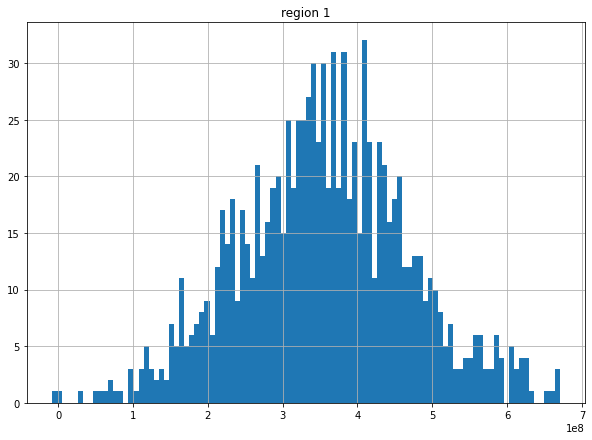

In [47]:
values_predict(predict_valid_1, 1)

Регион 2:
Средняя прибыль: 338 млн.руб.
Минимальная прибыль: 118 млн.руб.
Максимальная прибыль: 558 млн.руб.
95%-ый доверительный интервал: от 118 до 558 млн.руб.
Вероятность убытка 0.1000%



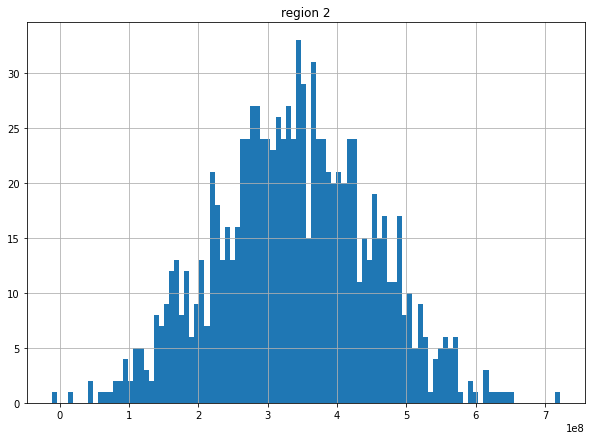

In [48]:
values_predict(predict_valid_2, 2)

Регион 3:
Средняя прибыль: 360 млн.руб.
Минимальная прибыль: 158 млн.руб.
Максимальная прибыль: 591 млн.руб.
95%-ый доверительный интервал: от 158 до 591 млн.руб.
Вероятность убытка 0.0000%



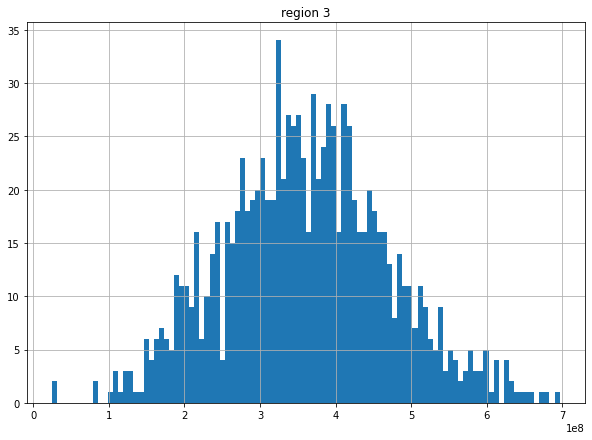

In [49]:
values_predict(predict_valid_3, 3)

**Вывод**

Построив модель отбора лучших скважин региона их списка прогнозных данных, мы достигли значений, значительно превышающих безубыточный уровень. 

Учитывая имеющийся уровень среднеквадратичного отклонения, мы не можем полагаться на показатели лучших скважин одной выборки. Поэтому, методом Bootstrap были сформированы 1000 выборок, по которым выявлено среднее значения прибыли региона. Все полученные значения выше безубыточного уровня. Ни один регион не показал вероятность убытка выше 2%

**Наивысший уровень прибыли достигается в третьем регионе**. Таким образом, разработку надо вести именно в этом регионе.